# Introduction

important information:
1. table with infomration coverd for all data used; (word document)
2. workflow/flow chart;
3. information for each omics;
4. clusting images;
5. survival analysis;
6. C-index of 12 different cancers;

## *Need to pay attention to the important of the multi-omics intergration in real world.

In [3]:
import pandas as pd
import numpy as np
import os
from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras import optimizers
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

def normalize(matric):
    temp = []
    for i in range(len(matric)):
        x = matric[i]
        x = np.array(x.reshape((len(x),1)))

        max_abs_scaler = preprocessing.MinMaxScaler()
        x = max_abs_scaler.fit_transform(x)
        x = x.reshape((len(x)))
        temp.append(x)
    return np.array(temp)

def train_test_set(val):
    temp = []

    sample = len(val[0])
    sample_width = sample

    for i in range(len(val)):
        temp.append(val[i][0:sample])

    val = temp
    
    train_x, test_x, train_y, test_y = train_test_split(val, val, test_size=0.4, random_state=32)
    
    train_x = normalize(train_x)
    train_y = normalize(train_y)
    test_x = normalize(test_x)
    test_y = normalize(test_y)

    train_x = np.reshape(train_x,(len(train_x),1,sample_width))
    train_y = np.reshape(train_y,(len(train_y),1,sample_width))
    test_x = np.reshape(test_x,(len(test_x),1,sample_width))
    test_y = np.reshape(test_y,(len(test_y),1,sample_width))
    
    return train_x,train_y,test_x,test_y

def autoencoder_model(val):
    sample = len(val[0])
    encoding_dim = sample

    input_img = Input(shape=((1,sample)))
    print(input_img)

    # encoder layers
    encoded = Dropout(0.2)
    encoded = Dense(1024, 
                kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l1(0.0001),
                activation='relu')(input_img)
    #encoded = Dense(512, 
    #            kernel_regularizer=regularizers.l2(0.001),
    #            activity_regularizer=regularizers.l1(0.0001),
    #            activation='relu')(encoded)
    encoder_output = Dense(256)(encoded)

    # decoder layers
    decoded = Dense(1024, 
                kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l1(0.0001),
                activation='relu')(encoder_output)
    #decoded = Dense(1024, 
    #            kernel_regularizer=regularizers.l2(0.001),
    #            activity_regularizer=regularizers.l1(0.0001),
    #            activation='relu')(decoded)
    decoded = Dense(encoding_dim, activation='tanh')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img,encoder_output)
    
    return encoder_output,autoencoder,encoder

def sur_data_process(file_name,summary):

    df_x = pd.read_csv(file_name,header=None, sep='\n')

    temp = []
    title = df_x[0][0].split('\t')

    for i in range(1,len(df_x[0])):
        if (int(i % 2)) == 0:
            temp.append(df_x[0][i].split('\t'))
        
    id_index = title.index('case_submitter_id')
    durtion_index = title.index('days_to_death')
    gender_index = title.index('gender')
    state_index = title.index('vital_status')
    stage_index = title.index('ajcc_pathologic_stage')

    data_matrix = []

    for i in range(len(temp)):
        lst = []
    
        lst.append(temp[i][id_index])
        
        if temp[i][durtion_index] == "'--":
            lst.append(0)
        else:    
            lst.append(int(temp[i][durtion_index]))
    
        lst.append(temp[i][gender_index])
    
        if temp[i][state_index] == 'Dead':
            lst.append(1)
        else:
            lst.append(0)
        
        if temp[i][stage_index] == 'Stage I' or temp[i][stage_index] == 'Stage IA' or temp[i][stage_index] == 'Stage IB' or temp[i][stage_index] == 'Stage IC':
            lst.append('Stage I')
        elif temp[i][stage_index] == 'Stage II' or temp[i][stage_index] =='Stage IIA' or temp[i][stage_index] =='Stage IIB' or temp[i][stage_index] =='Stage IIC':
            lst.append('Stage II')
        elif temp[i][stage_index] == 'Stage III' or temp[i][stage_index] =='Stage IIIA' or temp[i][stage_index] =='Stage IIIB' or temp[i][stage_index] =='Stage IIIC':
            lst.append('Stage III')
        elif temp[i][stage_index] == 'Stage IV' or temp[i][stage_index] =='Stage IVA' or temp[i][stage_index] =='Stage IVB' or temp[i][stage_index] =='Stage IVC':
            lst.append('Stage IV')
        
        df_temp = pd.read_csv(summary,sep = '\t')

        check = np.array(df_temp['Case ID'])

        #for j in range(len(df_temp['Case ID'])):
        #    check.append(df_temp['Case ID'][j])

        if temp[i][id_index] in check:
            data_matrix.append(lst)
    
    df_data = pd.DataFrame(data_matrix) 
    df_data.columns = ['Case ID','Durtion','Gender','State','Stage']

    return df_data

In [6]:
inp = os.getcwd()
file_name = inp + "/Breast_Gene_expression.csv"

df = pd.read_csv(file_name)
gene_site = list(df['Unnamed: 0'])
gene_expression_after_preprocessing = df.index = gene_site
gene_expression_after_preprocessing = df.drop(columns = ['Unnamed: 0'])

In [91]:
gene_expression_after_preprocessing

,TCGA-AR-A1AP,TCGA-A2-A0CS,11BR003,TCGA-BH-A0HK,TCGA-BH-A1FM,11BR014,TCGA-LL-A6FQ,TCGA-E9-A1R6,TCGA-LL-A73Y,TCGA-BH-A28O,...,TCGA-B6-A0IK,TCGA-A2-A1G4,TCGA-AR-A2LQ,TCGA-AC-A62Y,TCGA-A8-A0A4,TCGA-D8-A27G,TCGA-A2-A1FX,TCGA-WT-AB44,TCGA-BH-A0HB,TCGA-AC-A3TN
ENSG00000167578.15,0.006705,0.013605,0.067247,0.009030,0.003361,0.060010,0.025642,0.008649,0.016296,0.006330,...,0.006513,0.002170,0.004965,0.011212,0.004087,0.004934,0.007927,0.013738,0.009650,0.025321
ENSG00000078237.5,0.027102,0.030692,0.051421,0.018811,0.021246,0.012746,0.022559,0.015100,0.021448,0.011036,...,0.036194,0.026055,0.019431,0.044875,0.011749,0.029752,0.020081,0.025219,0.021252,0.013480
ENSG00000146083.10,0.028583,0.024017,0.013661,0.030151,0.016606,0.006023,0.012314,0.037588,0.033382,0.030918,...,0.032121,0.029348,0.018201,0.015818,0.022110,0.028060,0.026561,0.013772,0.029844,0.016466
ENSG00000158486.12,0.001127,0.000394,0.068247,0.000187,0.000137,0.075657,0.000007,0.000032,0.000295,0.000084,...,0.000330,0.000012,0.000058,0.000040,0.000168,0.000030,0.000022,0.000012,0.000159,0.000016
ENSG00000198242.12,0.012768,0.024633,0.000858,0.039648,0.019159,0.000476,0.063058,0.020041,0.013669,0.021569,...,0.012719,0.029458,0.016705,0.011510,0.020981,0.016780,0.020744,0.024381,0.104795,0.028172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000135094.9,0.032403,0.007385,0.041262,0.006358,0.002850,0.034194,0.018109,0.012020,0.002737,0.001745,...,0.005428,0.010249,0.007275,0.049104,0.002729,0.020786,0.025842,0.039771,0.024168,0.006249
ENSG00000009694.12,0.000261,0.000569,0.095505,0.000490,0.001061,0.079146,0.000053,0.000051,0.001641,0.002121,...,0.000328,0.000851,0.001495,0.000541,0.001430,0.001333,0.000218,0.000149,0.157066,0.000026
ENSG00000105063.17,0.036217,0.029195,0.018152,0.024450,0.014186,0.015042,0.031663,0.032152,0.023897,0.020440,...,0.037829,0.026983,0.022404,0.018013,0.026310,0.028775,0.023423,0.009507,0.030372,0.021847
ENSG00000231119.2,0.002477,0.001803,0.090163,0.001099,0.001441,0.074719,0.002239,0.002415,0.000552,0.001444,...,0.003308,0.005415,0.001677,0.001867,0.002076,0.001121,0.000996,0.001001,0.002259,0.004014


In [7]:
temp1 = np.array(gene_expression_after_preprocessing)
patient_number = np.shape(temp1)[1]
val_temp = []

for i in range(patient_number):
    gene_temp_lst = temp1[:,i]
    gene_lst = []
    
    for j in range(np.shape(temp1)[0]):
        ttmp = []
        ttmp.append(gene_temp_lst[j])
        gene_lst.append(ttmp)

    val_temp.append(gene_lst)
    
val = np.array(val_temp)

In [90]:
val

array([[[0.00670477],
        [0.02710188],
        [0.02858327],
        ...,
        [0.03621714],
        [0.00247701],
        [0.0031895 ]],

       [[0.01360455],
        [0.03069238],
        [0.02401729],
        ...,
        [0.02919492],
        [0.00180264],
        [0.00403146]],

       [[0.0672469 ],
        [0.05142095],
        [0.01366105],
        ...,
        [0.01815155],
        [0.09016256],
        [0.10996619]],

       ...,

       [[0.01373789],
        [0.02521919],
        [0.01377199],
        ...,
        [0.00950712],
        [0.00100145],
        [0.0327399 ]],

       [[0.00965   ],
        [0.02125156],
        [0.02984378],
        ...,
        [0.03037199],
        [0.00225879],
        [0.00753149]],

       [[0.02532139],
        [0.01348039],
        [0.01646646],
        ...,
        [0.0218469 ],
        [0.00401446],
        [0.00511003]]])

In [8]:
train_x,train_y,test_x,test_y = train_test_set(val) # set train and test set 

In [79]:
encoder_output,autoencoder,encoder = autoencoder_model(val)

Adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=Adam, loss='mse')
autoencoder.fit(train_x, train_y,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(test_x, test_y))

Tensor("input_11:0", shape=(None, 1, 25163), dtype=float32)
Train on 765 samples, validate on 511 samples
Epoch 1/50
765/765 [==============================] - 6s 8ms/step - loss: 2.5795 - val_loss: 2.0948
Epoch 2/50
765/765 [==============================] - 6s 8ms/step - loss: 1.9443 - val_loss: 1.7407
Epoch 3/50
765/765 [==============================] - 6s 8ms/step - loss: 1.6123 - val_loss: 1.4438
Epoch 4/50
765/765 [==============================] - 6s 8ms/step - loss: 1.3380 - val_loss: 1.1977
Epoch 5/50
765/765 [==============================] - 6s 8ms/step - loss: 1.1082 - val_loss: 0.9888
Epoch 6/50
765/765 [==============================] - 6s 8ms/step - loss: 0.9133 - val_loss: 0.8133
Epoch 7/50
765/765 [==============================] - 6s 8ms/step - loss: 0.7513 - val_loss: 0.6703
Epoch 8/50
765/765 [==============================] - 6s 8ms/step - loss: 0.6208 - val_loss: 0.5565
Epoch 9/50
765/765 [==============================] - 6s 8ms/step - loss: 0.5180 - val_loss: 0

KeyboardInterrupt: 

In [80]:
temp = np.reshape(val,(len(val),1,len(val[0])))

result_original = encoder.predict(temp)
result = np.reshape(result_original,(len(result_original),len(result_original[0][0])))

In [81]:
result

array([[-0.00060985,  0.00569298,  0.0014682 , ..., -0.007448  ,
         0.00417166, -0.00262893],
       [-0.00060985,  0.00569298,  0.0014682 , ..., -0.007448  ,
         0.00417166, -0.00262893],
       [-0.00115196,  0.00744433,  0.00306843, ..., -0.0081892 ,
         0.00342519, -0.00157271],
       ...,
       [-0.00060985,  0.00569298,  0.0014682 , ..., -0.007448  ,
         0.00417166, -0.00262893],
       [-0.00060985,  0.00569298,  0.0014682 , ..., -0.007448  ,
         0.00417166, -0.00262893],
       [-0.00060985,  0.00569298,  0.0014682 , ..., -0.007448  ,
         0.00417166, -0.00262893]], dtype=float32)

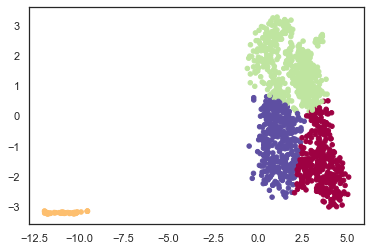

In [82]:
import sklearn.cluster as cluster
fig = plt.figure()
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
reducer = umap.UMAP()
embedding = reducer.fit_transform(result)
kmeans_labels = cluster.KMeans(n_clusters=4).fit_predict(embedding)
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, s=20, cmap='Spectral')

In [50]:
fig.savefig('umap_cluster.png')

# This is survival analysis base on model data

In [5]:
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

file_name = 'clinical.tsv'
summary = 'BRCA_Gene_expression.csv'
sur_temp = sur_data_process(file_name,summary)

sur_data = sur_temp.sort_values(by='Case ID')
sur_data.index = range(len(sur_data))
sur_temp

,Case ID,Durtion,Gender,State,Stage
0,TCGA-EW-A1PC,0,female,0,Stage II
1,TCGA-E2-A15T,0,female,0,Stage II
2,TCGA-A8-A09T,0,female,0,None
3,TCGA-A8-A06Q,0,female,0,Stage III
4,TCGA-AO-A0JI,0,female,0,Stage II
...,...,...,...,...,...
1153,TCGA-A2-A25E,0,female,0,Stage III
1154,TCGA-A8-A07G,0,female,0,Stage II
1155,TCGA-C8-A8HR,0,female,0,Stage III
1156,TCGA-AC-A3EH,197,female,1,Stage III


In [84]:
model_csv = pd.read_csv('Breast_Gene_expression.csv')
model_id = list(model_csv)

In [85]:
x_temp = sur_temp
temp_list = []

for i in range(len(model_id)-1):
    for j in range(len(x_temp)):
        if model_id[i] == x_temp['Case ID'][j]:
            if kmeans_labels[i] == 0:
                temp_list.append('Type 1')
            elif kmeans_labels[i] == 1:
                temp_list.append('Type 2')
            elif kmeans_labels[i] == 2:
                temp_list.append('Type 3')
            else:
                temp_list.append('Type 4')

temp_df = pd.DataFrame(temp_list) 
temp_df = temp_df.rename(columns={0:'Type'})
new_sur_temp = pd.concat([x_temp, temp_df], axis=1)
new_sur = new_sur_temp.dropna()
#new_sur = new_sur_old[new_sur_old['Durtion'] != 0]

In [86]:
new_sur.to_csv('Survival_analysis_gene_expression.csv')
new_sur

,Case ID,Durtion,Gender,State,Stage,Type
0,TCGA-EW-A1PC,0,female,0,Stage II,Type 3
1,TCGA-E2-A15T,0,female,0,Stage II,Type 2
3,TCGA-A8-A06Q,0,female,0,Stage III,Type 2
4,TCGA-AO-A0JI,0,female,0,Stage II,Type 3
5,TCGA-AC-A5XS,0,female,0,Stage II,Type 3
...,...,...,...,...,...,...
1074,TCGA-AN-A0FL,0,female,0,Stage II,Type 3
1075,TCGA-LL-A5YO,0,female,0,Stage I,Type 3
1076,TCGA-E9-A22D,0,female,0,Stage II,Type 3
1077,TCGA-AO-A0JJ,0,female,0,Stage II,Type 3


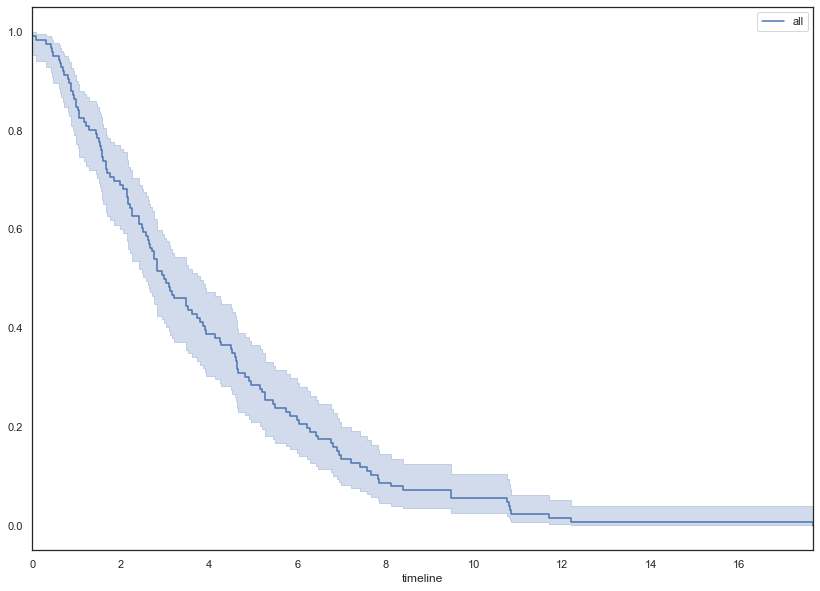

In [87]:
kmf = KaplanMeierFitter()
kmf.fit(new_sur['Durtion']/365, event_observed=new_sur['State'], label='all')
kmf.plot()

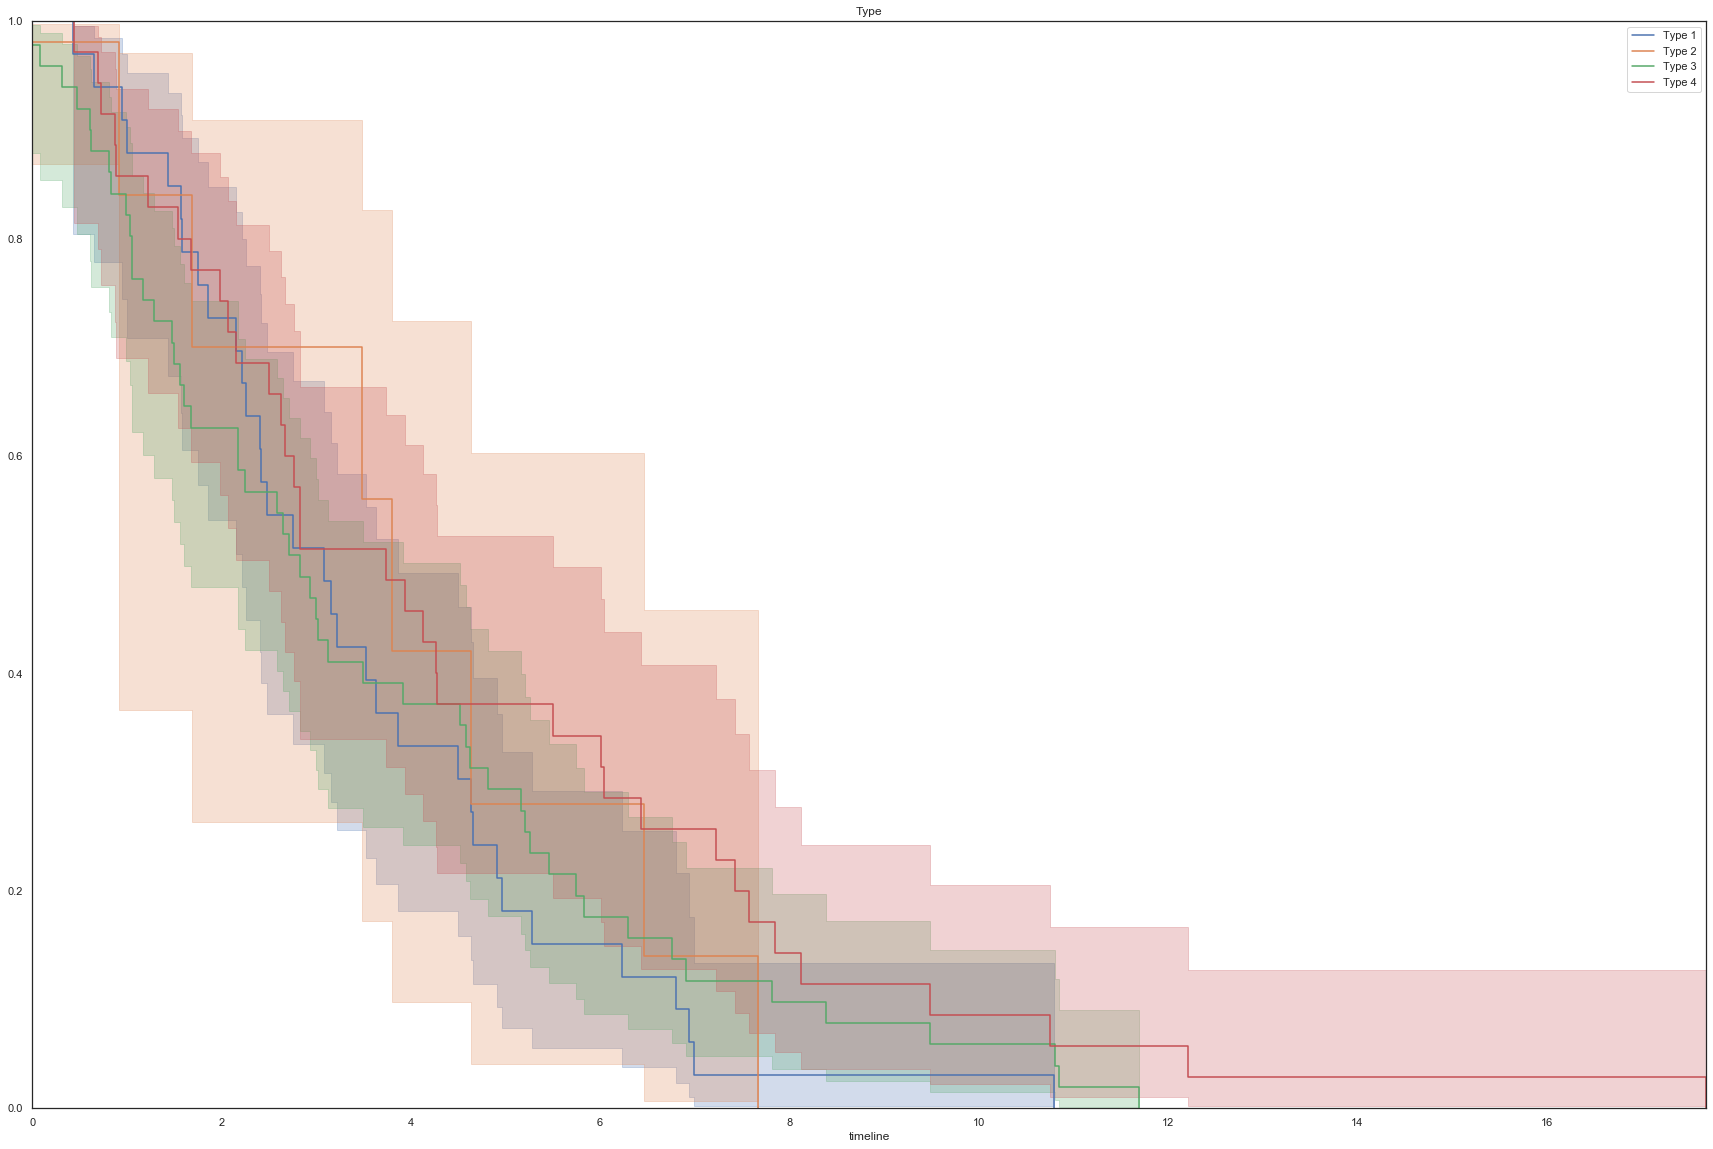

In [88]:
fig2 = plt.figure(figsize=(30,20))
ax = plt.subplot(111)

kmf.fit(new_sur[new_sur['Type'] == 'Type 1']['Durtion']/365, event_observed=new_sur[new_sur['Type'] == 'Type 1']['State'],label="Type 1")
ax = kmf.plot(ax=ax)

kmf.fit(new_sur[new_sur['Type'] == 'Type 2']['Durtion']/365, event_observed=new_sur[new_sur['Type'] == 'Type 2']['State'],label="Type 2")
ax = kmf.plot(ax=ax)

kmf.fit(new_sur[new_sur['Type'] == 'Type 3']['Durtion']/365, event_observed=new_sur[new_sur['Type'] == 'Type 3']['State'],label="Type 3")
ax = kmf.plot(ax=ax)

kmf.fit(new_sur[new_sur['Type'] == 'Type 4']['Durtion']/365, event_observed=new_sur[new_sur['Type'] == 'Type 4']['State'],label="Type 4")
ax = kmf.plot(ax=ax)

plt.ylim(0,1)
plt.title("Type");

In [ ]:
fig2.savefig('survival_analysis_gene.png')